In [1]:
!pip install pmdarima

In [2]:
# 
import pandas as pd
import numpy as np
%matplotlib inline

In [3]:
# импорт SARIMAX 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima 
# метрики
from statsmodels.tools.eval_measures import rmse
# для игнорирования предупреждений (опционально)
import warnings
warnings.filterwarnings("ignore")
# Загрузка датасета
df = pd.read_csv('HospitalityEmployees.csv',index_col='Date',parse_dates=True)
df.index.freq = 'MS'
print(len(df))
print(df.head())

348
            Employees
Date                 
1990-01-01     1064.5
1990-02-01     1074.5
1990-03-01     1090.0
1990-04-01     1097.4
1990-05-01     1108.7


In [4]:
# В df 348 записей и 1 колонка. Данные представляют собой численность сотрудников в тысячах человек в среднем за месяц с янв1990 года по дек2018 года.

# 1. Построение графика временного ряда

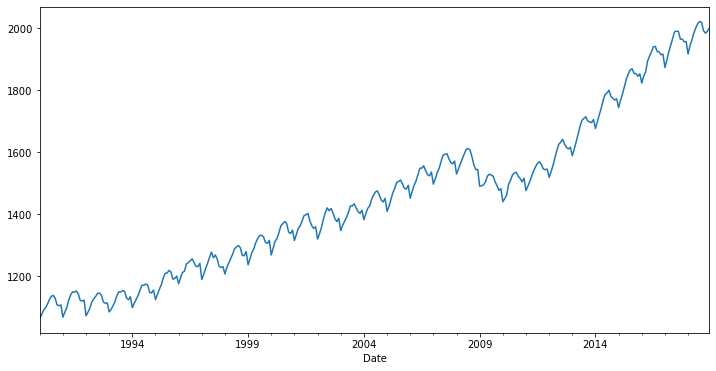

In [5]:
## Постройте график атрибута 'Employees'
df.Employees.plot(figsize=(12,6));

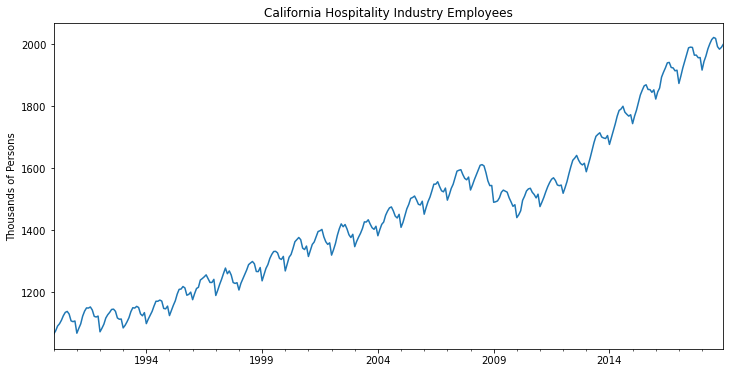

In [6]:
# добавьте заголовок и подписи
ax = df.Employees.plot(figsize=(12,6))
title = 'California Hospitality Industry Employees'
ylabel='Thousands of Persons'
xlabel=''
ax.set(title=title, xlabel=xlabel, ylabel=ylabel);

# 2. Выполнение ETS декомпозиции

In [7]:
# Используя аддитивную модель ('additive'). Подсказка: функция seasonal_decompose

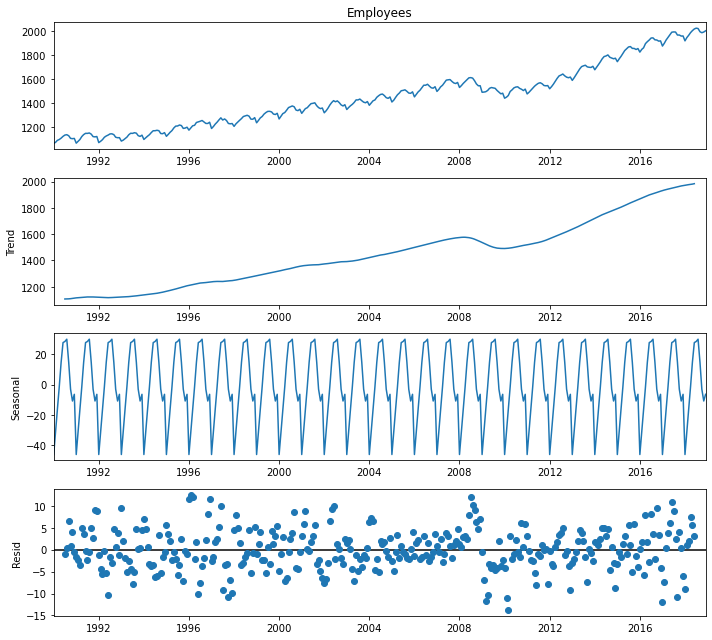

In [8]:
# задаем размер графика
from pylab import rcParams
rcParams['figure.figsize'] = 10, 9
result = seasonal_decompose(df.Employees) # model='additive' default
result.plot();

# 3. Запуск pmdarima.auto_arima чтобы получить набор параметров

In [9]:
auto_arima(df.Employees, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  348
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1098.252
Date:                              Mon, 28 Mar 2022   AIC                           2208.504
Time:                                      06:01:18   BIC                           2231.600
Sample:                                           0   HQIC                          2217.700
                                              - 348                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9244      0.045     20.530      0.000       0.836       1.013
ma.L1         -0.9440      0.070    -13.474      0.000      -1.081      -0.807
ma.L2          0.1288      0.060      2.150      0.032       0.011       0.246
ar.S.L12       0.9972      0.001    705.126      0.000       0.994       1.000
ma.S.L12      -0.7489      0.043    -17.324      0.000      -0.834      -0.664
sigma2        29.2970      1.717     17.064      0.000      25.932      32.662
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                67.43
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.11
Prob(H) (two-sided):                  0.40   Kurtosis:                         5.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 4. Разделение данные на train/test

In [10]:
#Устанавливаем один последний год /12 записей/ для тестирования. Есть несколько способов сделать это.

In [11]:
#train = df.iloc[:len(df)-12]
#test = df.iloc[len(df)-12:]
train = df.iloc[:-12]
test = df.iloc[-12:]

# 5. Обучение SARIMA(1,1,2)x(1,0,1,12) на train['Employees']

In [12]:
model = SARIMAX(train.Employees, order=(1, 1, 2), seasonal_order=(1, 0, 1, 12) )
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Employees   No. Observations:                  336
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1058.058
Date:                              Mon, 28 Mar 2022   AIC                           2128.116
Time:                                      06:01:19   BIC                           2151.001
Sample:                                  01-01-1990   HQIC                          2137.240
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9241      0.043     21.265      0.000       0.839       1.009
ma.L1         -0.9584      0.070    -13.682      0.000      -1.096      -0.821
ma.L2          0.1498      0.061      2.460      0.014       0.030       0.269
ar.S.L12       0.9973      0.001    726.037      0.000       0.995       1.000
ma.S.L12      -0.7518      0.044    -17.154      0.000      -0.838      -0.666
sigma2        28.7659      1.684     17.079      0.000      25.465      32.067
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                73.33
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.17
Prob(H) (two-sided):                  0.63   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
#Warnings: [1] Covariance matrix calculated using the outer product of gradients (complex-step).

# 6. Получение прогнозируемых значений

In [14]:
start = len(train)
end = len(df)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,1,2)x(1,0,1,12)Predictions')


# 7. Рисуем графики прогнозируемых и известных значений

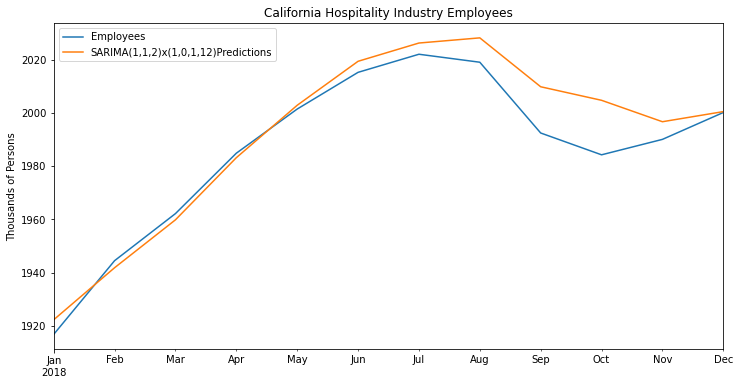

In [15]:
title = 'California Hospitality Industry Employees'
ylabel='Thousands of Persons'
xlabel=''
ax = test.Employees.plot(figsize=(12,6))
predictions.plot()
ax.autoscale(axis='x',tight=True)
ax.legend()
ax.set(title=title,
xlabel=xlabel,
ylabel=ylabel);

# 8. Оценка качество модели с помощью MSE и RMSE

In [16]:
from sklearn.metrics import mean_squared_error
mse_value = mean_squared_error(test.Employees, predictions)
rmse_value = rmse(test.Employees, predictions)
print(f'SARIMA(1,1,2)x(1,0,1,12) MSE Error: {mse_value:11.10}')
print(f'SARIMA(1,1,2)x(1,0,1,12) RMSE Error: {rmse_value:11.10}')

SARIMA(1,1,2)x(1,0,1,12) MSE Error: 77.68616713
SARIMA(1,1,2)x(1,0,1,12) RMSE Error: 8.813975671


# 9. Тренируем модель на полном датасете и предсказываем на год вперед

In [17]:
model = SARIMAX(df.Employees, order=(1, 1, 2), seasonal_order=(1, 0, 1, 12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Employees   No. Observations:                  348
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1098.252
Date:                              Mon, 28 Mar 2022   AIC                           2208.504
Time:                                      06:01:20   BIC                           2231.600
Sample:                                  01-01-1990   HQIC                          2217.700
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9244      0.045     20.530      0.000       0.836       1.013
ma.L1         -0.9440      0.070    -13.474      0.000      -1.081      -0.807
ma.L2          0.1288      0.060      2.150      0.032       0.011       0.246
ar.S.L12       0.9972      0.001    705.126      0.000       0.994       1.000
ma.S.L12      -0.7489      0.043    -17.324      0.000      -0.834      -0.664
sigma2        29.2970      1.717     17.064      0.000      25.932      32.662
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                67.43
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.11
Prob(H) (two-sided):                  0.40   Kurtosis:                         5.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
# прогнозируем на 12 месяцев
fcast = results.predict(len(df)-1,len(df)+11,typ='levels').rename('SARIMA(1,1,2)x(1,0,1,12) Forecast')

# 10. Построим график предсказаний и график исходных данных

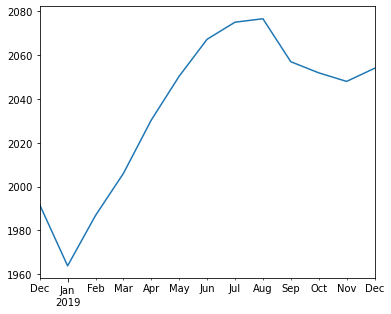

In [19]:
fcast.plot(figsize=(6,5));

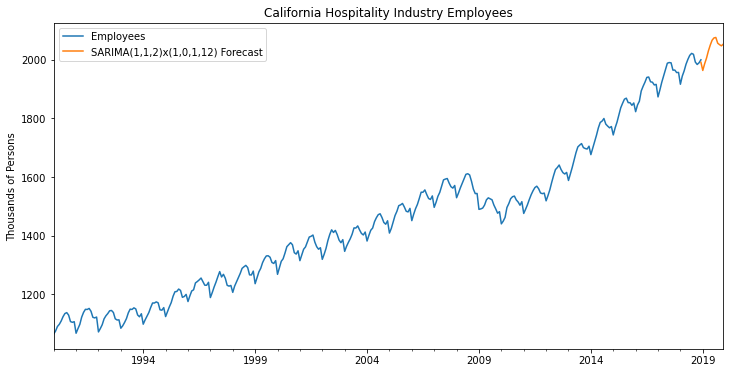

In [20]:
# отобразим общий график
ax = df.Employees.plot(figsize=(12,6))
fcast.plot()
title = 'California Hospitality Industry Employees'
ylabel='Thousands of Persons'
xlabel=''
ax.legend()
ax.set(title=title, xlabel=xlabel, ylabel=ylabel);

# Использование библиотеки Prophet Импорт библиотеки и данных

In [ ]:
!pip install pystan==2.19.1.1

In [ ]:
!pip3 install prophet
from prophet import Prophet

In [ ]:
df = pd.read_csv('HospitalityEmployees.csv')
df.rename(columns={'Date': 'ds', 'Employees':'y'}, inplace=True)
df['ds'] = pd.to_datetime(df.ds)

# Создание и обучение модели

In [ ]:
m = Prophet()
m.fit(df)

# Создание диапазона дат и предсказание данных

In [ ]:
future = m.make_future_dataframe(periods=12, freq='MS')
forecast = m.predict(future)

# Построение графика

In [ ]:
forecast.set_index('ds', inplace=True)
forecast.rename(columns={'yhat': 'Prophet Forecast'}, inplace=True)
df.set_index('ds', inplace=True)
df.rename(columns={'y':'Employees'}, inplace=True)

In [ ]:
ax = df['Employees'].plot(figsize=(12,6))
forecast['Prophet Forecast'].plot()
title = 'California Hospitality Industry Employees'
ylabel='Thousands of Persons'
xlabel=''
ax.legend()
ax.set(title=title, xlabel=xlabel, ylabel=ylabel);

# Оценка ошибок модели

In [ ]:
start = 0
end = len(df)
mse_value = mean_squared_error(df.Employees.iloc[start:], forecast['Prophet Forecast'].iloc[start:end])
rmse_value = rmse(df.Employees.iloc[start:], forecast['Prophet Forecast'].iloc[start:end])
print(f'Prophet Forecast MSE Error: {mse_value:11.10}')
print(f'Prophet Forecast RMSE Error: {rmse_value:11.10}')

In [ ]:
# Ошибка предсказаний модели Prophet несколько выше модели SARIMA, но общее время, затрачиваемое на настройку модели, нивелирует эти недостатки